# CCF Planet Finder
### Purpose: to find planet in data cube when you cannot see it with your eyes


In [17]:
import glob
from scipy.signal import convolve, boxcar
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import os, sys
import time
from astropy.table import Table
from astropy.io import fits
import copy
import scipy.io as spio
import matplotlib.image as mpimg


import astropy.constants as const
import astropy.units as u

#import CCF

### Read in fits data cube
#### primary hdu contains the data

In [18]:
hdul = fits.open('s161106_a022002_tlc_Kbb_020.fits')
hdul.info()
cube = hdul[0].data
#pixel = cube[9,32,:]

Filename: s161106_a022002_tlc_Kbb_020.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU     434   (1665, 64, 19)   float32   
  1                1 ImageHDU         8   (1665, 64, 19)   float32   
  2                1 ImageHDU         8   (1665, 64, 19)   uint8   


### Need the wavlength information from the fits file 

In [19]:
Wavelengths = hdul[0].header['CRVAL1'] + np.arange(hdul[0].header['NAXIS1']) * hdul[0].header['CDELT1']
#this is for OSIRIS

In [20]:
def load_osiris_cube(filename):
    """ Load OSIRIS cube 
    
    Returns (cube, wavelengths array, header)
    """
    hdul = fits.open(filename)
    hdul.info() 
    cube = hdul[0].data
   

    Wavelengths = hdul[0].header['CRVAL1'] + np.arange(hdul[0].header['NAXIS1']) * hdul[0].header['CDELT1']
    Wavelengths = Wavelengths * u.nm
    return cube, Wavelengths, hdul[0].header


In [21]:
cube, Wavelengths, header = load_osiris_cube('s161106_a022002_tlc_Kbb_020.fits')

Filename: s161106_a022002_tlc_Kbb_020.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU     434   (1665, 64, 19)   float32   
  1                1 ImageHDU         8   (1665, 64, 19)   float32   
  2                1 ImageHDU         8   (1665, 64, 19)   uint8   


In [22]:
import astropy.wcs

In [23]:
coords = astropy.wcs.WCS(header)

In [24]:
coords

WCS Keywords

Number of WCS axes: 3
CTYPE : 'WAVE'  'DEC--TAN'  'RA---TAN'  
CRVAL : 1.9650000000000002e-06  44.33378118  355.11025092  
CRPIX : 1.0  32.0  9.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  0.801775627654  -0.597625169232  
PC3_1 PC3_2 PC3_3  : 0.0  -0.597625169232  -0.801775627654  
CDELT : 2.5e-10  5.55556e-06  5.55556e-06  
NAXIS : 1665  64  19

In [25]:
Wavelengths

<Quantity [1965.  , 1965.25, 1965.5 , ..., 2380.5 , 2380.75, 2381.  ] nm>

In [26]:
#convert Wavlengths to microns for consistency
Wavelengths = Wavelengths /1000 *u.micron

### Need model to cross correlate for the planet signal 
#### Model needs to be close in spectral type to planet you're searching for 

In [39]:
#t3 = np.genfromtxt('2048_377_0_1_1.txt')
#cowaves = t3[:,1]*u.micron
#cofluxes = t3[:,0]

t3 = np.genfromtxt('ccf_kappa_mod.txt')
cowaves = t3[:,0] *u.micron
cofluxes = t3[:,1]

(1, 3)

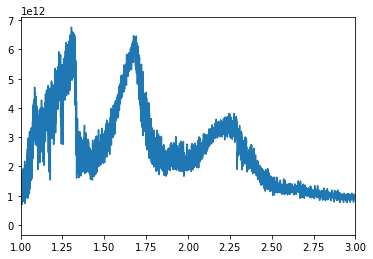

In [40]:
plt.plot(cowaves, cofluxes)
plt.xlim([1,3])

In [29]:
#need to read in 51 Eri spec for GJ 504 b
#erib = '51Erib_model_osiris_k.sav' #sav data file
#moreerib = spio.readsav(erib, python_dict=True, verbose=True) #seeing whats in it
#eriwaves = moreerib['wavek'] #getting wavelength info
#erifluxes = moreerib['f_mod_k'] #getting flux info


### RV information

In [49]:
#RV of Star km/s (go to simbad) Kappa And 
rv = -12.7 * u.km/u.second
#baryrv nov 6 2016 km/s: (need mjd-obs and to convert to JD)
baryrv = -10.3 * u.km/u.second
#speed of light in km/s:
c_kms = 299792.458 *u.km/u.second

### Interpolate model to match RV

In [58]:
def interpolate_model_to_rv(wavelengths, modwaves, fluxes, rv, baryrv):
    """Use spline interpolation to shift a spectrum based on velocities"""

    #assuming rv same as host star and keeping it constant, wavelengths = of the data itself
    wvs_shifted= wavelengths*(1 - ((rv-baryrv) / c_kms))
    
    #interpolating the model
    spline = scipy.interpolate.splrep(modwaves, fluxes)
    
    #taking above model and creating a doppler shifted spectra of the model
    shifted_spec = scipy.interpolate.splev(wvs_shifted, spline, der=0)
    
    return shifted_spec


In [60]:
shifted_spec = interpolate_model_to_rv(Wavelengths, cowaves, cofluxes, rv, baryrv)

In [35]:
#filtmod = shifted_spec

### Smooth model and remove spikes

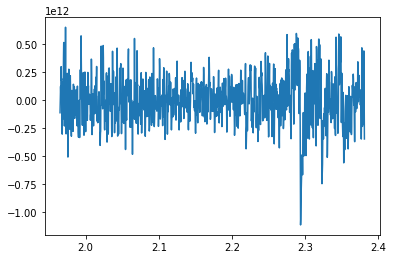

In [71]:
#smoothing the model spectra to get the continuum
smoothedmod = scipy.ndimage.filters.uniform_filter(shifted_spec,size=200)
#subtracting the continuum out
filtmod = shifted_spec - smoothedmod
plt.plot(Wavelengths, filtmod)
#this method caused some sharp spikes, so here we identify which parts are spikes
#spikes = np.where(np.abs(filtmod) > 3*np.std(filtmod)) #locations in cube where spikes are, if getting rid of too much info set it higher to 3
#We make the spikes equal to the median of the spectra
#filtmod[spikes]=np.median(filtmod)
#plt.plot(Wavelengths, filtmod)


In [72]:
#define array for 2d ccf image
corr_im = np.zeros((19,64))
#print(cube.shape)
#x,y=10,30
#smoothed=scipy.ndimage.filters.uniform_filter(cube[x,y,:],size=200) #smoothing pixel flux
#filt = cube[x,y,:] - smoothed #flatten the fluxes
#plt.plot(Wavelengths,filt)
#spikes = np.where(np.abs(filt) > 2*np.std(filt)) #locations in cube where spikes are, if getting rid of too much info set it higher to 3
#filt[spikes]=np.median(filt) #setting spikes to median value
#plt.plot(Wavelengths,filt)

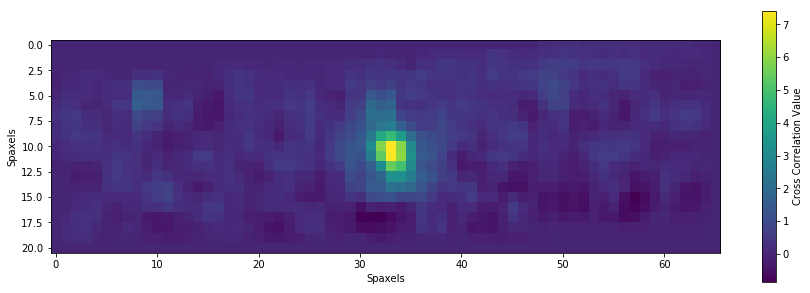

In [70]:
#looping through cubes (0,18) (0,63)
for x in range(0,18):
    for y in range(0,63):
        #print(cube[x,y,:])
        smoothed=scipy.ndimage.filters.uniform_filter(cube[x,y,:],size=200) #smoothing pixel flux
        filt = cube[x,y,:] - smoothed #flatten the fluxes
        spikes = np.where(np.abs(filt) > 2*np.std(filt)) #locations in cube where spikes are, if getting rid of too much info set it higher to 3
        filt[spikes]=np.median(filt) #setting spikes to median value
        ccfval = np.sum(filt * filtmod) / np.sqrt(np.sum((filtmod) ** 2)) #cross correlate model with data
        #print(ccfval)
        corr_im[x,y] = ccfval   #put ccf value into array
        #plt.plot(Wavelengths, filt)
        #plt.show()
        #print(spikes)
        
        

corr_im = scipy.signal.correlate2d(corr_im, np.ones((3,3)))
plt.figure(figsize=(15,5))
plt.imshow(corr_im)
plt.xlabel("Spaxels")
plt.ylabel("Spaxels")

cb = plt.colorbar()
cb.set_label("Cross Correlation Value")
plt.show()


In [35]:
def ccf(cube, model, plot=True):
    """Calculate Cross Correlation Function
    
    """
    #smoothing the model spectra to get the continuum
    smoothedmod = scipy.ndimage.filters.uniform_filter(shifted_spec,size=200)
    #subtracting the continuum out
    filtmod = shifted_spec - smoothedmod
    #this method caused some sharp spikes, so here we identify which parts are spikes
    spikes = np.where(np.abs(filtmod) > 3*np.std(filtmod)) #locations in cube where spikes are, if getting rid of too much info set it higher to 3
    #We make the spikes equal to the median of the spectra
    filtmod[spikes]=np.median(filtmod)
    #define array for 2d ccf image
    corr_im = np.zeros((19,64))
    #print(cube.shape)

    #looping through cubes (0,18) (0,63)
    for x in range(0,18):
        for y in range(0,63):
            #print(cube[x,y,:])
            smoothed=scipy.ndimage.filters.uniform_filter(cube[x,y,:],size=200) #smoothing pixel flux
            filt = cube[x,y,:] - smoothed #flatten the fluxes
            spikes = np.where(np.abs(filt) > 2*np.std(filt)) #locations in cube where spikes are, if getting rid of too much info set it higher to 3
            filt[spikes]=np.median(filt) #setting spikes to median value
            ccfval = np.sum(filt * filtmod) / np.sqrt(np.sum((filtmod) ** 2)) #cross correlate model with data
            #print(ccfval)
            corr_im[x,y] = ccfval   #put ccf value into array
            #plt.plot(Wavelengths, filt)
            #plt.show()
            #print(spikes)

    if plot: 
        plt.figure(figsize=(15,5))
        plt.imshow(corr_im)
        plt.xlabel("Spaxels")
        plt.ylabel("Spaxels")

        cb = plt.colorbar()
        cb.set_label("Cross Correlation Value")
        plt.show()

    return corr_im
    

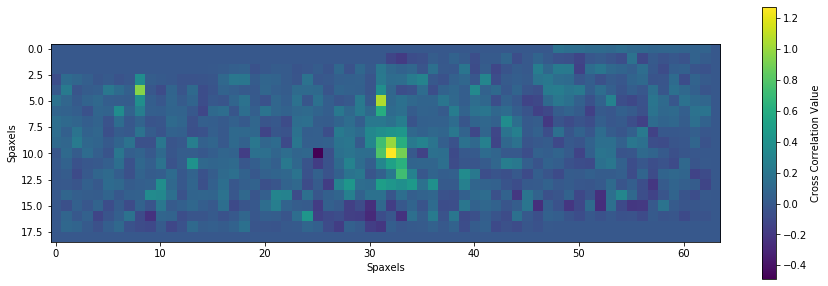

In [36]:
result = ccf(cube, shifted_spec, plot=True)

In [64]:
result = ccf(cube, shifted_spec, plot=False)

In [ ]:
# Example - iterating this calculation over many possible input

for input_spectrum in some_list_of_spectra:
    waves, fluxes = load_spectrum(input_spectrum)
    
    shifted_spec = interpolate_model_to_rv(waves, fluxes, rv, baryrv)
    
    result = ccf(cube, shifted_spec)